##Duplicate Question Pairs Detection using Machine Learning

In [1]:
!pip install Unidecode
!pip3 install fuzzywuzzy
!pip install distance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import pickle
import string
import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from os import path
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import csv
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


     |████████████████████████████████| 235 kB 21.4 MB/s 
     |████████████████████████████████| 180 kB 16.1 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=467ba35d3b3018a3f8aa55044ea2b59f0decb4ee4aa564172d444140d0b1c262
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Dataset/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [4]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

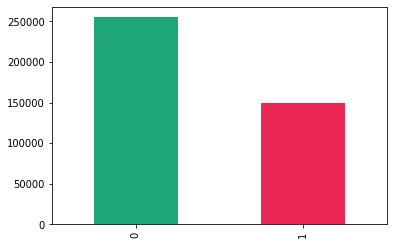

In [7]:
df['is_duplicate'].value_counts().plot.bar(color=['#1ea676','#eb2657'])

In [8]:
print("Total number of questions: {}".format(df.shape[0]))

Total number of questions: 404290


In [9]:
# number of duplicate and non-duplicate questions

print("Question pairs that are not similar (is_duplicate=0): {}".format(
    round((df['is_duplicate'] == 0).sum() * 100 / df.shape[0], 2)))

print("Question pairs that are similar (is_duplicate=1): {}".format(
round((df['is_duplicate'] == 1).sum() * 100 / df.shape[0], 2)))

Question pairs that are not similar (is_duplicate=0): 63.08
Question pairs that are similar (is_duplicate=1): 36.92


In [10]:
round((df['is_duplicate'] == 0).sum() / df.shape[0], 2)

0.63

In [11]:
# distribution of questions

questions = pd.concat([df['question1'], df['question2']])
questions_uniq = questions.unique()
questions_more_than_one = (questions.value_counts() > 1).sum()

print("Total number of questions: {}".format(questions.shape[0]))
print("Total number of unique questions: {}".format(questions_uniq.shape[0]))
print("Total number of duplicate questions occuring more than once: {} %".format(
    round(questions_more_than_one / questions_uniq.shape[0] * 100, 2)))
print("Maximum occurence of single repeated question: {}".format(questions.value_counts().max()))

Total number of questions: 808580
Total number of unique questions: 537361
Total number of duplicate questions occuring more than once: 20.82 %
Maximum occurence of single repeated question: 161


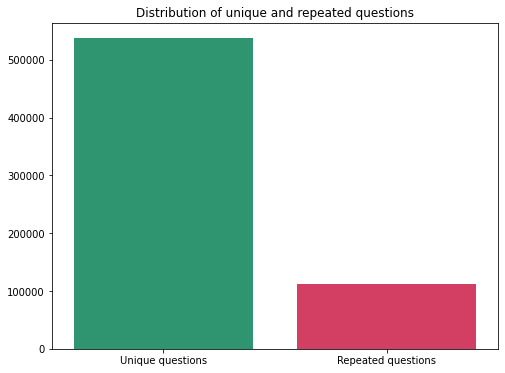

In [12]:
x = ['Unique questions', 'Repeated questions']
y = [questions_uniq.shape[0], questions_more_than_one]
plt.figure(figsize=(8, 6))
plt.title('Distribution of unique and repeated questions')
sns.barplot(x, y,palette=['#1ea676','#eb2657'])
plt.show()

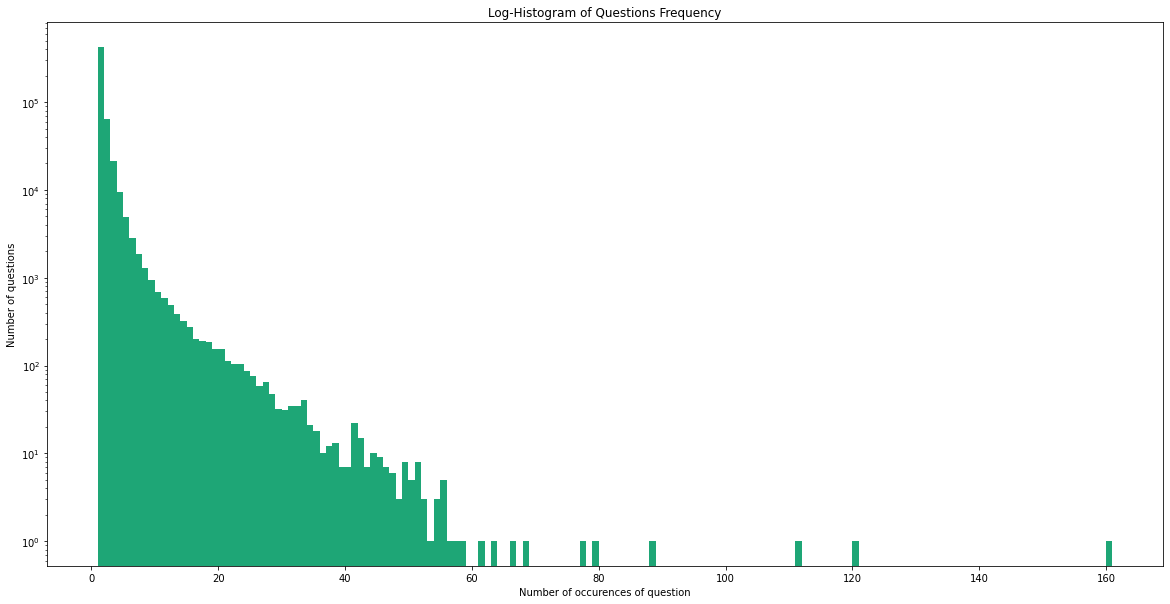

In [13]:
# histogram of questions frequency
plt.figure(figsize=(20, 10))
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Questions Frequency')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.hist(questions.value_counts(), bins=160,color = "#1ea676")
plt.show()

In [14]:
# check missing values
df.isnull().sum()

question1       1
question2       2
is_duplicate    0
dtype: int64

In [15]:
# checking the empty rows
empty_rows = df[df.isnull().any(1)]
empty_rows

,question1,question2,is_duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


In [16]:
# deleting the empty rows
df.drop(empty_rows.index, inplace=True)

###Feature extraction

In [17]:
# extracting the features from data
df['q1_len'] = df['question1'].apply(lambda x: len(x))
df['q2_len'] = df['question2'].apply(lambda x: len(x))
df['q1_word_len'] = df['question1'].apply(lambda x: len(x.split(' ')))
df['q2_word_len'] = df['question2'].apply(lambda x: len(x.split(' ')))
df['q1_char_len'] = df['question1'].apply(lambda x: len(x.replace(' ', '')))
df['q2_char_len'] = df['question2'].apply(lambda x: len(x.replace(' ', '')))
df['len_diff'] = df.apply(lambda x: abs(x['q1_len'] - x['q2_len']), axis=1)
df['word_len_diff'] = df.apply(lambda x: abs(x['q1_word_len'] - x['q2_word_len']), axis=1)
df['char_len_diff'] = df.apply(lambda x: abs(x['q1_char_len'] - x['q2_char_len']), axis=1)
df['common_words'] = df.apply(lambda x: len(
    set(x['question1'].lower().split(' ')) & set(x['question2'].lower().split(' '))), axis=1)
df['common_words_ratio'] = df.apply(lambda x: x['common_words'] / (x['q1_word_len'] + x['q2_word_len']), axis=1)

In [18]:
df.iloc[:, 2:].head()

,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio
0,0,66,57,14,12,53,46,9,2,7,10,0.384615
1,0,51,88,8,13,44,76,37,5,32,4,0.190476
2,0,73,59,14,10,60,50,14,4,10,4,0.166667
3,0,50,65,11,9,40,57,15,2,17,0,0.000000
4,0,76,39,13,7,64,33,37,6,31,2,0.100000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   question1           404287 non-null  object 
 1   question2           404287 non-null  object 
 2   is_duplicate        404287 non-null  int64  
 3   q1_len              404287 non-null  int64  
 4   q2_len              404287 non-null  int64  
 5   q1_word_len         404287 non-null  int64  
 6   q2_word_len         404287 non-null  int64  
 7   q1_char_len         404287 non-null  int64  
 8   q2_char_len         404287 non-null  int64  
 9   len_diff            404287 non-null  int64  
 10  word_len_diff       404287 non-null  int64  
 11  char_len_diff       404287 non-null  int64  
 12  common_words        404287 non-null  int64  
 13  common_words_ratio  404287 non-null  float64
dtypes: float64(1), int64(11), object(2)
memory usage: 46.3+ MB


In [20]:
print("Minimum length of the questions in question 1: {}".format(min(df['q1_len'])))
print("Minimum length of the questions in question 2: {}".format(min(df['q2_len'])))

print("Number of questions with minimum length in question 1: {}".format((df['q1_len'] == 1).sum()))
print("Number of questions with minimum length in question 2: {}".format((df['q2_len'] == 1).sum()))

Minimum length of the questions in question 1: 1
Minimum length of the questions in question 2: 1
Number of questions with minimum length in question 1: 19
Number of questions with minimum length in question 2: 2


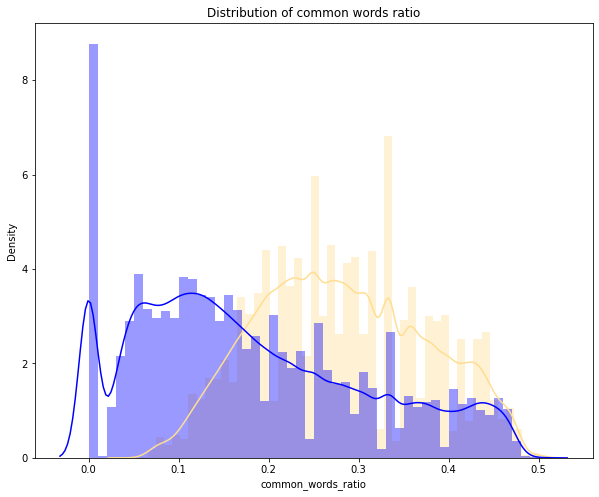

In [21]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of common words ratio')
sns.distplot(df[df['is_duplicate'] == 1]['common_words_ratio'], label = "1", color = '#ffde91')
sns.distplot(df[df['is_duplicate'] == 0]['common_words_ratio'], label = "0", color = 'blue')
plt.show()

###Text Preprocessing

In [22]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [23]:
x="<p>Hello world</p>"
print(x)
remove_html_tags(x)

<p>Hello world</p>


'Hello world'

In [24]:
# words with accent marks
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

remove_accented_chars('café')

'cafe'

In [25]:
# expand contractions
cList = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expand_contractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

print(expand_contractions('You won\'t live.'))

You will not live.


In [26]:
# remove comma between numbers
def remove_comma_between_numbers(text):
    return re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

print(remove_comma_between_numbers("55,000"))

55000


In [27]:
# load stop words and stemmer
>>> import nltk
>>> nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
def clean(text, remove_html=True, remove_punctuation=True):

    text = text.lower()

    if remove_html:
        text = remove_html_tags(text)

    text = remove_accented_chars(text)
    text = expand_contractions(text)
    text = remove_comma_between_numbers(text)

    # remove punctuation (optional)
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # remove stop words
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]

    # stemming using porter
    stemmed_text = [porter.stem(w) for w in filtered_text]
    text = ' '.join(filtered_text)

    return text

In [29]:
  >>> import nltk
  >>> nltk.download('punkt')
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
for i in range(10):
    print(df.question1[i])
    print(df.question2[i])
    print('')

step step guide invest share market india
step step guide invest share market

story kohinoor kohinoor diamond
would happen indian government stole kohinoor kohinoor diamond back

increase speed internet connection using vpn
internet speed increased hacking dns

mentally lonely solve
find remainder math2324math divided 2423

one dissolve water quikly sugar salt methane carbon di oxide
fish would survive salt water

astrology capricorn sun cap moon cap risingwhat say
im triple capricorn sun moon ascendant capricorn say

buy tiago
keeps childern active far phone video games

good geologist
great geologist

use shi instead shi
use instead

motorola company hack charter motorolla dcx3400
hack motorola dcx3400 free internet



In [31]:
df_duplicate = df[df['is_duplicate'] == 1]
df_non_duplicate = df[df['is_duplicate'] == 0]

In [32]:
# merge question1 and question2 in duplicate and non_duplicate dataset

p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten()

print("Number of data points in class 1 (duplicate pairs): ", len(p))
print("Number of data points in class 0 (non duplicate pairs): ", len(n))

# saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs):  298526
Number of data points in class 0 (non duplicate pairs):  510048


In [33]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 9951438
Total number of words in non duplicate pair questions : 20830838


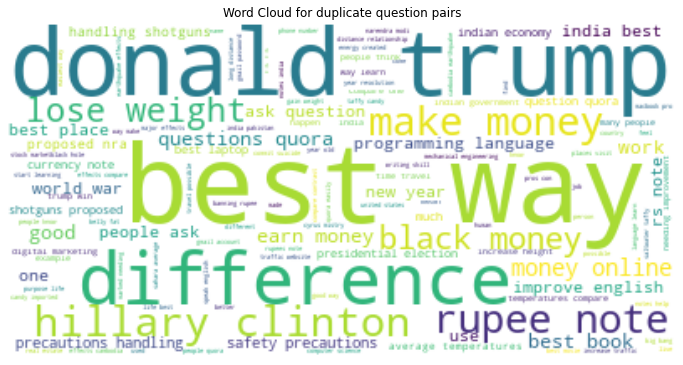

In [34]:
# word cloud for duplicate questions pair

plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
plt.title("Word Cloud for duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

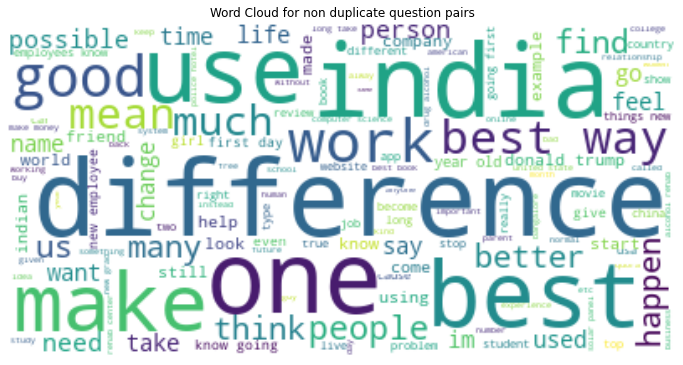

In [35]:
# word cloud for non duplicate questions pair

plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
plt.title("Word Cloud for non duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###Advanced Feature extraction

In [36]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)

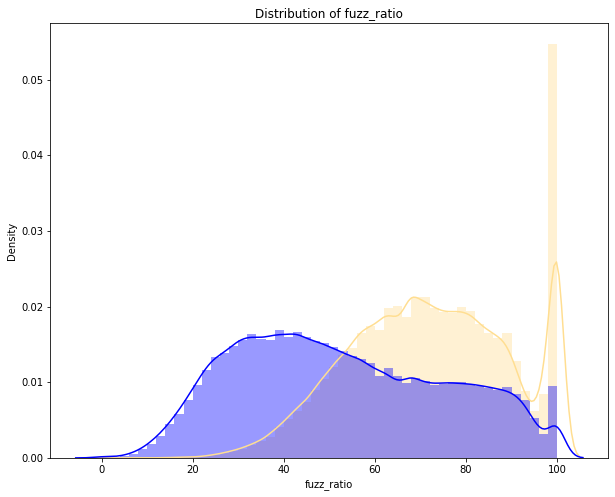

In [37]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of fuzz_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['fuzz_ratio'], label = "1", color = '#ffde91')
sns.distplot(df[df['is_duplicate'] == 0]['fuzz_ratio'], label = "0", color = 'blue')
plt.show()

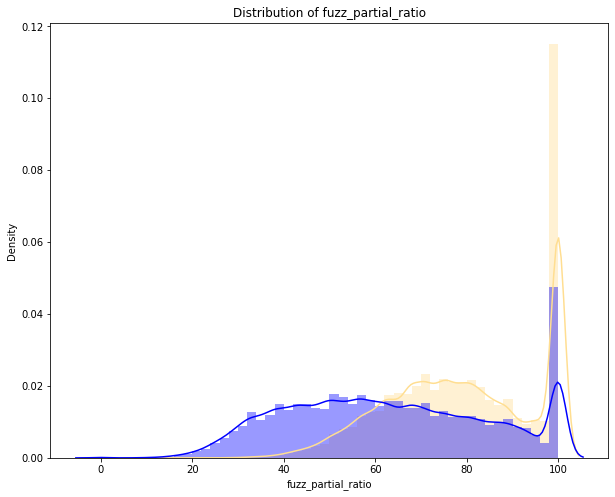

In [38]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of fuzz_partial_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['fuzz_partial_ratio'], label = "1", color = '#ffde91')
sns.distplot(df[df['is_duplicate'] == 0]['fuzz_partial_ratio'], label = "0", color = 'blue')
plt.show()

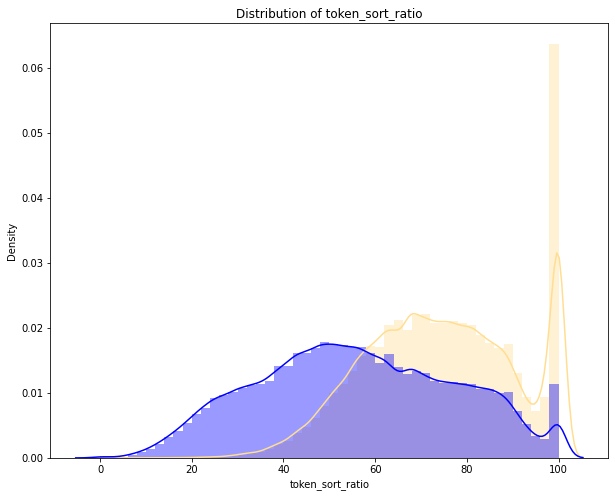

In [39]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of token_sort_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['token_sort_ratio'], label = "1", color = '#ffde91')
sns.distplot(df[df['is_duplicate'] == 0]['token_sort_ratio'], label = "0", color = 'blue')
plt.show()

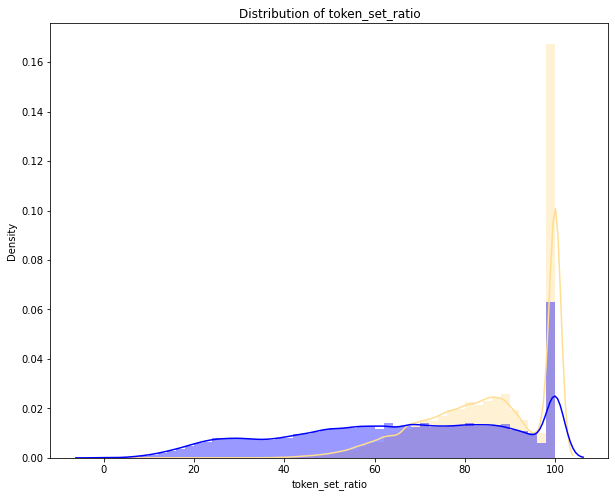

In [40]:
plt.figure(figsize=(10, 8))
plt.title('Distribution of token_set_ratio')
sns.distplot(df[df['is_duplicate'] == 1]['token_set_ratio'], label = "1", color = '#ffde91')
sns.distplot(df[df['is_duplicate'] == 0]['token_set_ratio'], label = "0", color = 'blue')
plt.show()

In [41]:
df.head(10)

,question1,question2,is_duplicate,q1_len,q2_len,q1_word_len,q2_word_len,q1_char_len,q2_char_len,len_diff,word_len_diff,char_len_diff,common_words,common_words_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,53,46,9,2,7,10,0.384615,92,100,92,100
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,51,88,8,13,44,76,37,5,32,4,0.190476,59,94,59,84
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,60,50,14,4,10,4,0.166667,55,46,65,65
3,mentally lonely solve,find remainder math2324math divided 2423,0,50,65,11,9,40,57,15,2,17,0,0.000000,23,24,20,20
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,76,39,13,7,64,33,37,6,31,2,0.100000,25,52,40,51
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,86,90,16,16,71,75,4,0,4,8,0.250000,64,65,50,69
6,buy tiago,keeps childern active far phone video games,0,19,62,4,11,16,52,43,7,36,0,0.000000,19,33,19,19
7,good geologist,great geologist,1,30,41,7,9,24,33,11,2,9,4,0.250000,76,71,76,78
8,use shi instead shi,use instead,0,31,37,8,8,24,30,6,0,6,6,0.375000,73,82,73,100
9,motorola company hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0,60,49,9,9,52,41,11,0,11,3,0.166667,51,65,51,75


In [42]:
df.to_pickle("./questions_preprocessed.pkl")